In [1]:
import sys, os, re, random, warnings, pickle
sys.path.append(os.path.dirname(os.getcwd()))
from config import *

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ss_inference.model import NetSurfP2, ConvNet

from utils import *
from ssqa import *
from data import *
from pgm import *

warnings.filterwarnings("ignore")

torch.set_num_threads(32)
torch.cuda.is_available()

In [3]:
DATASET = "russ"
MUT_DATASET = "mutfromeccm"
DATA = PFAM_DATA
batch_size = 300

In [4]:
nat_seq = "TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPVRDIDRERDLLERLITLGKAHHLDAHYITRLFQLIIEDSVLTQQALLQQH"
uniprot_id = "P0A9J8"
pattern = c_pattern3, n_pattern3, c_pattern8, n_pattern8 = search_pattern(f"{DATA}/{MUT_DATASET}", uniprot_id, nat_seq)[0]

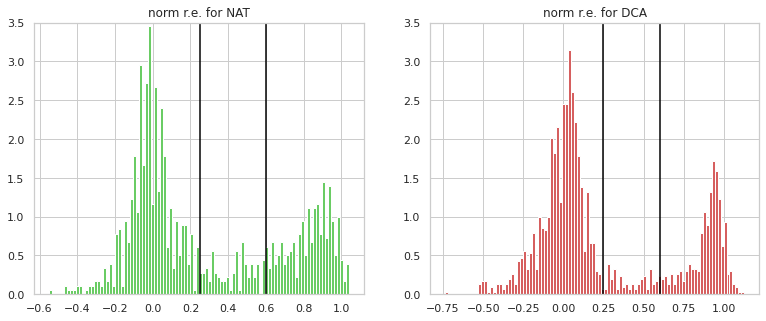

In [5]:
df = pd.read_csv(f"{DATA}/{DATASET}/table_seq.csv")
df["T"] = df["T"].fillna(0)
df["is_active"] = df["norm r.e."].apply(lambda x : int(x >= 0.6))
df["is_inactive"] = df["norm r.e."].apply(lambda x : int(x < 0.6))
df["edca_below_50"] = df["EDCA (rel. to EcCM)"].apply(lambda e : int(e < 50))
df["edca_below_25"] = df["EDCA (rel. to EcCM)"].apply(lambda e : int(e < 25))
df["edca"] = -df["EDCA (rel. to EcCM)"]/94

plt.figure(figsize = (13,5))
for i, (name, col) in enumerate(zip(['NAT', 'DCA'], ["g","r"])):
    plt.subplot(1, 2, i+1)
    plt.ylim(0,3.5)
    plt.plot([0.25,0.25],[-0.5, 4],c="black")
    plt.plot([0.6,0.6],[-0.5, 4], c="black")
    plt.hist(df[df.origin == name]["norm r.e."], bins = 100, color = col, density = True)
    plt.title(f"norm r.e. for {name}")
    
cond_train = (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0)
cond_test = (df.origin == "DCA")  & ((df.is_active + df.is_inactive) > 0)

y_train = df[cond_train]["is_active"].values
y = df["is_active"].values
plt.show()

In [ ]:
df["edca"] = df["EDCA (rel. to EcCM)"]/94

We compute the MSA Log Reg to compare

In [17]:
cond_train = (df.origin == "NAT") & df.edca_below_50
cond_test = (df.origin == "DCA") & df.edca_below_50

X = dataset.seqs.view(dataset.seqs.size(0), -1)
X_train = X[cond_train]
X_test = X[cond_test]

y = df["is_active"].values
y_train = y[cond_train]
y_test = y[cond_test]

clf = LogisticRegression()
clf.fit(X_train, y_train)
df["MSALogReg"] = clf.predict_proba(X)[:,1]

accuracy_score(y_test,torch.tensor(clf.predict_proba(X_test)[:,1]>0.8))

0.7491228070175439

## RBM model

We can use our own RBM metric or the one from Russ et al. Here is how to use our own.

Available :  seq L cluster_index weights subset seq_hmm pattern ss_hmm


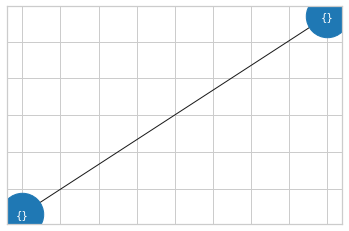

Iteration 0 : -0.0037315369118005037
Iteration 200 : 1.628682324582769
Iteration 400 : 6.817449551926984
Iteration 600 : 16.19811455245508
Iteration 800 : 31.279992599891557
Iteration 1000 : 55.01963660578622
Iteration 1200 : 93.17121647755994
Iteration 1400 : 153.53361489336385
Iteration 1600 : 239.33396138708486
Iteration 1800 : 348.1990791753997
Estimated Z : 9.929


9.928821563720703

In [74]:
device = "cpu"
dataset_rbm = SSQAData_RBM(f"{DATA}/{DATASET}/data.pt")
loader = DataLoader(dataset_rbm, batch_size = 100, shuffle = True)
batch_size, q, N = dataset_rbm.seqs.size()

pots = torch.zeros(q+1, N)
for v, w in dataset_rbm:
    pots += w*v
pots /= torch.sum(dataset_rbm.weights)
pots = (pots-pots.mean(0)[None]).view(-1).float().to(device)

visible_layers = ["sequence"]
hidden_layers = ["hidden"]

v = OneHotLayer(pots, N=N, q=q+1, name="sequence")
h = GaussianLayer(N=200, name="hidden")

E = [(v.name, h.name)]

model1 = MRF(layers = {v.name: v,
                    h.name: h},
            edges = E,
            name = "")

for visible in visible_layers:
    edge = model1.get_edge(visible, "hidden")
    
model1.load(f"{DATA}/{DATASET}/weights/seq-reg-200_4320.h5")
model1.ais(n_inter = 2000, verbose = True)

In [21]:
data_rbm = torch.cat([data[None] for data, _ in dataset_rbm],0)
df["edca"] = model1.integrate_likelihood({"sequence":data_rbm}, "hidden").detach()/data_rbm.size(-1) - model1.Z

## SSQA

In [6]:
dataset = SSQAData_QA(f"{DATA}/{DATASET}/data.pt")

loader = DataLoader(dataset, batch_size = 16, shuffle = False)

device = torch.device('cuda')

model_ss = NetSurfP2(50, "netsurfp2")
model_ss.load_state_dict(torch.load(f"{UTILS}/nsp_50feats.h5"))
model_ss = model_ss.to(device)

model_ss

Available :  seq L cluster_index weights subset seq_hmm pattern ss_hmm


Model netsurfp2-50

In [7]:
nat_idx = list(df[(df["is_active"]) & (df["origin"] == "NAT")].index)
idx_size = torch.zeros(96)
ss_hmm3 = torch.zeros(3, 96)
ss_hmm8 = torch.zeros(8, 96)
for i in tqdm(nat_idx):
    ss_hmm = torch.tensor(dataset[i]).float()
    active_idx = torch.where((ss_hmm[:20].sum(0) > 0))[0]
    inactive_idx = torch.where((ss_hmm[:20].sum(0) == 0))[0]

    idx_size[active_idx] += 1
    pred = model_ss(ss_hmm[None, :, active_idx].cuda())
    ss_hmm3[:, active_idx] += F.softmax(pred[2][0],0).cpu()
    ss_hmm8[:, active_idx] += F.softmax(pred[1][0],0).cpu()
    #SS_HMM3[:, inactive_idx] += 1/3
    #SS_HMM8[:, inactive_idx] += 1/8

ss_hmm3 = ss_hmm3[None]/idx_size
ss_hmm8 = ss_hmm8[None]/idx_size

push(f"{DATA}/{DATASET}/data.pt", "ss_hmm", (ss_hmm3, ss_hmm8))
push(f"{DATA}/{MUT_DATASET}/data.pt", "ss_hmm", (ss_hmm3, ss_hmm8))

seq_hmm = dataset.seq_hmm
pattern = dataset.c_pattern3, dataset.n_pattern3, dataset.c_pattern8, dataset.n_pattern8

100%|██████████| 352/352 [00:07<00:00, 50.20it/s]


In [46]:
X = torch.cat([data[None] for data in dataset],0)
ssqa = SSQA(model_ss, pattern, seq_hmm, ss_hmm3, ss_hmm8)
dp, pm = ssqa.featuring(X)

In [47]:
ssqa.train(dp[cond_train], pm[cond_train], y_train)
ssqa.save(f"{DATA}/{DATASET}/ssqa.pt")

In [56]:
dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(dp, pm)

df["dp_sup"] = dpsup
df["pm_sup"] = pmsup
df["dp_unsup"] = dpunsup
df["pm_unsup"] = pmunsup

df["ssqa_unsup"] = pmunsup
df["ssqa_sup"] = (0.5*pmsup + dpsup)/1.5

## Russ Generated Data

In [50]:
from sklearn.metrics import *
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import *
from sklearn.ensemble import *

from scipy.stats import spearmanr, rankdata


def where(a, conditioning):
    return a[df[conditioning].index.values]


def best_temperature(X, y):
    X = edca, m1, m2, m3, m4
    clf = LogisticRegression()
    Xunsup = clf.fit(torch.cat([edca[:,None],m1[:,None],m2[:,None]],1),y)
    a,b,c = clf.coef_[0][0], clf.coef_[0][1], clf.coef_[0][2]
    Wunsup = a/(a+b+c),b/(a+b+c),c/(a+b+c)
    
    Xsup = clf.fit(torch.cat([edca[:,None],m3[:,None],m4[:,None]],1),y)
    a,b,c = clf.coef_[0][0], clf.coef_[0][1], clf.coef_[0][2]
    Wsup = a/(a+b+c),b/(a+b+c),c/(a+b+c)
    return Wunsup, Wsup

def compute_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    return auc(fpr, tpr)

In [51]:
conds = {
         "NAT": (df.origin == "NAT") & ((df.is_active + df.is_inactive) > 0),
         "DCA": (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0),
         "DCA ($E_{DCA} \textless 50$)": (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0) & (df.edca_below_50),

         "DCA ($E_{DCA} \textless 25$)": (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0) & (df.edca_below_25),
         "DCA (T = 0.33)": (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0) & (df["T"] == 0.33),
         "DCA (T = 0.66)": (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0) & (df["T"] == 0.66),
         "DCA (T = 1.0)": (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0) & (df["T"] == 1.),}
all_scores = dict()
s = ""
for name, cond in conds.items():
    print(name)
    y = torch.tensor(df["is_active"][cond].values)
    dp_sup = df["dp_sup"][cond]
    pm_sup = df["pm_sup"][cond]
    dp_unsup = df["dp_unsup"][cond]
    pm_unsup = df["pm_unsup"][cond]
    edca = -torch.exp(-torch.tensor(df["edca"][cond].values))
    id1 = torch.tensor(df["ID to EcCM"][cond].values)
    id2 = torch.tensor(df["IdLogReg"][cond].values)

    m1 = torch.tensor(dp_unsup.values)
    m2 = torch.tensor(pm_unsup.values)
    m3 = torch.tensor(dp_sup.values)
    m4 = torch.tensor(pm_sup.values)

    (wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature([edca, m1, m2, m3, m4], y)
         
    f1scores = dict()
    f1scores["MSALogReg"] = compute_auc(y, id2)
    f1scores["E"] = compute_auc(y, edca)
        
    print(f"Supervised : ws_e = {ws_e:.2f}, ws_dp = {ws_dp:.3f}, w_pm = {ws_pm:.3f}, ws_pm/ws_dp: {ws_pm/ws_dp:.3f}")
    f1scores["sup/DP"] = compute_auc(y, m3)
    f1scores["sup/PM"] = compute_auc(y, m4)
    f1scores["sup/PM+DP"] = compute_auc(y, ws_dp * m3 + ws_pm * m4)
    f1scores["sup/E+DP"] = compute_auc(y, ws_e * edca + ws_dp * m3)
    f1scores["sup/E+PM"] = compute_auc(y, ws_e * edca + ws_pm * m4)
    f1scores["sup/E+DP+PM"] = compute_auc(y, ws_e * edca  + ws_dp * m3 + ws_pm * m4)
    
    print(f"Unsupervised : ws_e = {wu_e:.2f}, ws_dp = {wu_dp:.3f}, w_pm = {wu_pm:.3f}, ws_pm/ws_dp: {wu_pm/wu_dp:.3f}")
    f1scores["unsup/DP"] = compute_auc(y, m1)
    f1scores["unsup/PM"] = compute_auc(y, m2)
    f1scores["unsup/PM+DP"] = compute_auc(y, wu_dp * m1 + wu_pm * m2)
    f1scores["unsup/E+DP"] = compute_auc(y, wu_e * edca + wu_dp * m1)
    f1scores["unsup/E+PM"] = compute_auc(y, wu_e * edca + wu_pm * m2)
    f1scores["unsup/E+DP+PM"] = compute_auc(y, wu_e * edca + wu_dp * m1 + wu_pm * m2)
    
    for k, v in f1scores.items():
        print(f"{k} : {v:.3f}")
    print()
    s += f'\multicolumn{{1}}{{|l|}}{{\textbf{{{name}}}}} & {f1scores["IdLogReg"]:.3f} & {f1scores["E"]:.3f} & {f1scores["unsup/DP"]:.3f} & {f1scores["unsup/PM"]:.3f} & {f1scores["unsup/E+DP"]:.3f} & {f1scores["unsup/E+PM"]:.3f} & {f1scores["unsup/E+DP+PM"]:.3f} & {f1scores["sup/DP"]:.3f} & {f1scores["sup/PM"]:.3f} & {f1scores["sup/E+DP"]:.3f} & {f1scores["sup/E+PM"]:.3f} & {f1scores["sup/E+DP+PM"]:.3f} \\'
    all_scores[name] = f1scores

NAT
Supervised : ws_e = -0.02, ws_dp = 0.517, w_pm = 0.502, ws_pm/ws_dp: 0.970
Unsupervised : ws_e = -0.12, ws_dp = 0.281, w_pm = 0.838, ws_pm/ws_dp: 2.980
IdLogReg : 1.000
E : 0.459
sup/DP : 1.000
sup/PM : 1.000
sup/PM+DP : 1.000
sup/E+DP : 1.000
sup/E+PM : 1.000
sup/E+DP+PM : 1.000
unsup/DP : 0.610
unsup/PM : 0.636
unsup/PM+DP : 0.642
unsup/E+DP : 0.563
unsup/E+PM : 0.637
unsup/E+DP+PM : 0.641

DCA
Supervised : ws_e = 0.31, ws_dp = 0.492, w_pm = 0.193, ws_pm/ws_dp: 0.393
Unsupervised : ws_e = 0.29, ws_dp = 0.237, w_pm = 0.469, ws_pm/ws_dp: 1.979
IdLogReg : 0.814
E : 0.772
sup/DP : 0.774
sup/PM : 0.739
sup/PM+DP : 0.781
sup/E+DP : 0.900
sup/E+PM : 0.846
sup/E+DP+PM : 0.903
unsup/DP : 0.633
unsup/PM : 0.686
unsup/PM+DP : 0.697
unsup/E+DP : 0.780
unsup/E+PM : 0.804
unsup/E+DP+PM : 0.810

DCA ($E_{DCA} 	extless 50$)
Supervised : ws_e = 0.28, ws_dp = 0.524, w_pm = 0.193, ws_pm/ws_dp: 0.367
Unsupervised : ws_e = 0.25, ws_dp = 0.253, w_pm = 0.502, ws_pm/ws_dp: 1.982
IdLogReg : 0.838
E : 0.6

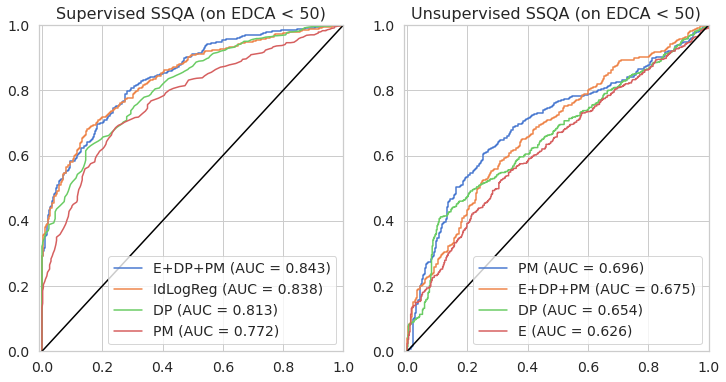

In [86]:
cond = (df.origin == "DCA") & ((df.is_active + df.is_inactive) > 0) & (df.edca_below_50)
y = torch.tensor(df["is_active"][cond].values)
dp_sup = df["dp_sup"][cond]
pm_sup = df["pm_sup"][cond]
dp_unsup = df["dp_unsup"][cond]
pm_unsup = df["pm_unsup"][cond]
edca = -torch.exp(-torch.tensor(df["edca"][cond].values))
id1 = torch.tensor(df["ID to EcCM"][cond].values)
id2 = torch.tensor(df["IdLogReg"][cond].values)

m1 = torch.tensor(dp_unsup.values)
m2 = torch.tensor(pm_unsup.values)
m3 = torch.tensor(dp_sup.values)
m4 = torch.tensor(pm_sup.values)

(wu_e, wu_dp, wu_pm), (ws_e, ws_dp, ws_pm) = best_temperature([edca, m1, m2, m3, m4], y)

legs = []
plt.figure(figsize=(12,6))

plt.subplot(121)
fpr, tpr, _ = roc_curve(1-y, -(ws_e * edca  + ws_dp * m3 + ws_pm * m4))
plt.plot(fpr, tpr)
legs.append(f"E+DP+PM (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -id2)
plt.plot(fpr, tpr)
legs.append(f"IdLogReg (AUC = {auc(fpr, tpr):.3f})")


fpr, tpr, _ = roc_curve(1-y, -m3)
plt.plot(fpr, tpr)
legs.append(f"DP (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -m4)
plt.plot(fpr, tpr)
legs.append(f"PM (AUC = {auc(fpr, tpr):.3f})")

plt.legend(legs,fontsize=14)
plt.title("Supervised SSQA (on EDCA < 50)", fontsize=16)
plt.plot([0,1], [0,1], c="black")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-0.01,1)
plt.ylim(0,1)

legs= []

plt.subplot(122)
fpr, tpr, _ = roc_curve(1-y, -m2)
plt.plot(fpr, tpr)
legs.append(f"PM (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -(ws_e * edca  + ws_dp * m1 + ws_pm * m2))
plt.plot(fpr, tpr)
legs.append(f"E+DP+PM (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -m1)
plt.plot(fpr, tpr)
legs.append(f"DP (AUC = {auc(fpr, tpr):.3f})")

fpr, tpr, _ = roc_curve(1-y, -edca)
plt.plot(fpr, tpr)
legs.append(f"E (AUC = {auc(fpr, tpr):.3f})")

plt.legend(legs,fontsize=14)
plt.title("Unsupervised SSQA (on EDCA < 50)", fontsize=16)
plt.plot([0,1], [0,1], c="black")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-0.01,1)
plt.ylim(0,1)
plt.show()

In [96]:
T1 = np.linspace(20, 20, 25)
T2 = np.linspace(0.5, 0.5, 25)
best_acc, t = 0,None
for t1 in T1:
    for t2 in T2:
        sub = df[(df.origin == "DCA") & (df["EDCA (rel. to EcCM)"]< t1) & (df["ssqa_sup"] > t2)].is_active
        acc = sub.mean()
        N = len(sub)
        if acc > best_acc:
            best_acc = acc
            t = (t1, t2, N, acc)
best_acc

0.822463768115942

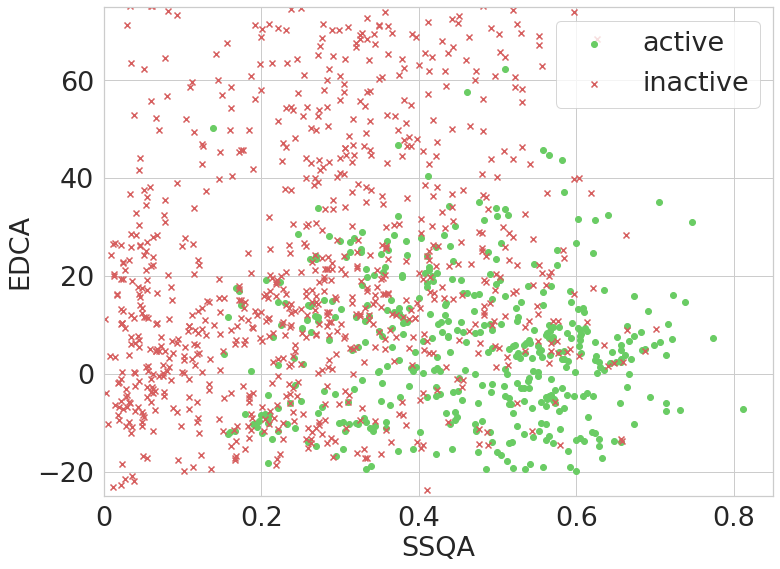

In [54]:
plt.figure(figsize=(12,9))
plt.scatter(df["ssqa_sup"][(df.origin == "DCA") & (df.is_active == 1)],
            df["EDCA (rel. to EcCM)"][(df.origin == "DCA") & (df.is_active == 1)],
            c="g", marker="o")
plt.scatter(df["ssqa_sup"][(df.origin == "DCA") & (df.is_active == 0)], 
            df["EDCA (rel. to EcCM)"][(df.origin == "DCA") & (df.is_active == 0)], 
             c="r", marker="x")
plt.legend(["active", "inactive"], fontsize=27)
#plt.plot((t[1],t[1]), [-50,t[0]], c = "black")
#plt.plot([t[1],100], (t[0],t[0]), c = "black")
plt.xlabel("SSQA", fontsize=27)
plt.ylabel("EDCA", fontsize=27)
plt.xlim(0,0.85)
plt.ylim(-25, 75)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8], [0, 0.2, 0.4, 0.6, 0.8], fontsize=27)
plt.yticks(fontsize=27)
plt.title("SSQA sup and EDCA of generated samples (85% active in the black box)", fontsize=21)
plt.show()

print(spearmanr(df["ssqa_sup"][(df.origin == "DCA") & (df.is_active == 1)& (df.edca_below_50)],
            df["IdLogReg"][(df.origin == "DCA") & (df.is_active == 1)& (df.edca_below_50)],))

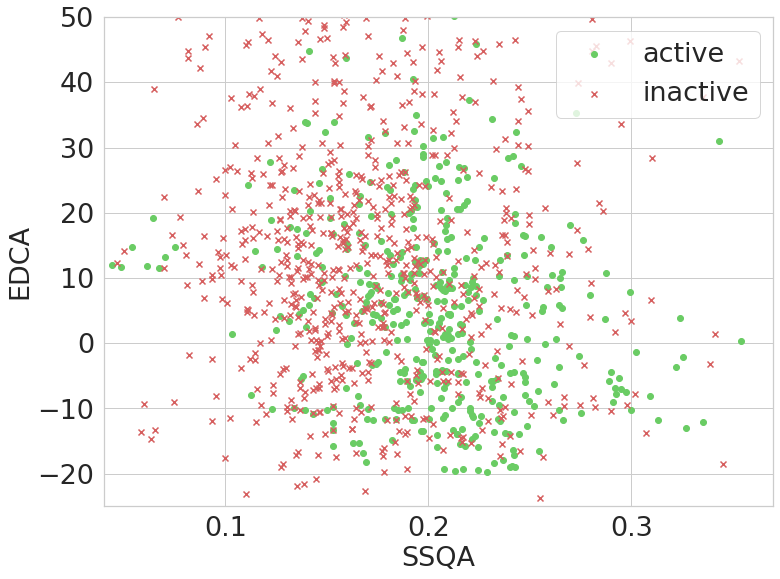

In [70]:
plt.figure(figsize=(12,9))
plt.scatter(df["ssqa_unsup"][(df.origin == "DCA") & (df.is_active == 1)],
            df["EDCA (rel. to EcCM)"][(df.origin == "DCA") & (df.is_active == 1)],
            c="g", marker="o")
plt.scatter(df["ssqa_unsup"][(df.origin == "DCA") & (df.is_active == 0)], 
            df["EDCA (rel. to EcCM)"][(df.origin == "DCA") & (df.is_active == 0)], 
             c="r", marker="x")
plt.legend(["active", "inactive"], fontsize=27)
plt.xlabel("SSQA", fontsize=27)
plt.ylabel("EDCA", fontsize=27)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4], [0, 0.1, 0.2, 0.3, 0.4], fontsize=27)
plt.yticks(fontsize=27)
plt.ylim(-25, 50)
plt.xlim(0.04, 0.37)

plt.title("SSQA unsup and EDCA of generated samples", fontsize=21)
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(df["norm r.e."][(df.origin == "DCA") & df.is_active], 
            comb[df.origin == "NAT"], c="g", marker="o", s=4)
plt.scatter(df["norm r.e."][(df.origin == "DCA") & (~df.is_active)], 
            comb[df.origin == "DCA"], c="r", marker="x", s=4)
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("Structure QA")
plt.xlim(-0.8, 1.25)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA)")

plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df[(df.origin == "NAT")]["norm r.e."].values, 
            df[(df.origin == "NAT")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="g", marker="x")
plt.scatter(df[(df.origin == "DCA")]["norm r.e."].values, 
            df[(df.origin == "DCA")]["EDCA (rel. to EcCM)"].values, s = 4.0, c="b", marker="x")
plt.legend(["NAT", "DCA"])
plt.xlabel("Ground Truth norm r.e.")
plt.ylabel("E_DCA")
# plt.xlim(-0.8, 1.25)
# plt.ylim(-0.01, 0.85)
plt.title("E_DCA of natural (NAT) and generated (DCA)")

plt.show()

plt.figure(figsize=(6,6))
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["struct QA"], 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 1)]["EDCA (rel. to EcCM)"].values, c="g", marker="o", s=5)
plt.scatter(df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["struct QA"], 
            df[(df.edca_below_50 <= 1) &(df.origin =="DCA") & (df.is_active == 0)]["EDCA (rel. to EcCM)"].values, c="r", marker="x", s=5)
plt.legend(["active", "inactive"], loc = 1)
plt.xlabel("Structure QA")
plt.ylabel("E_DCA")
plt.ylim(-25, 75)
plt.title("Structure E_DCA function of Structure QA")

plt.show()

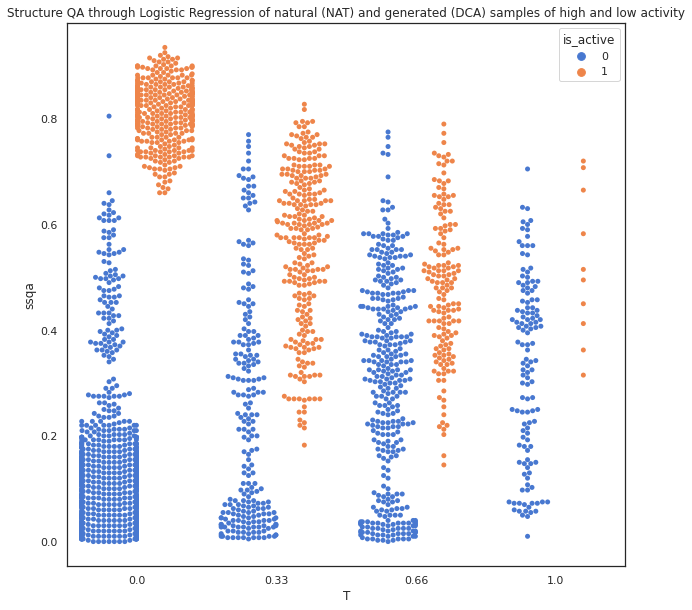

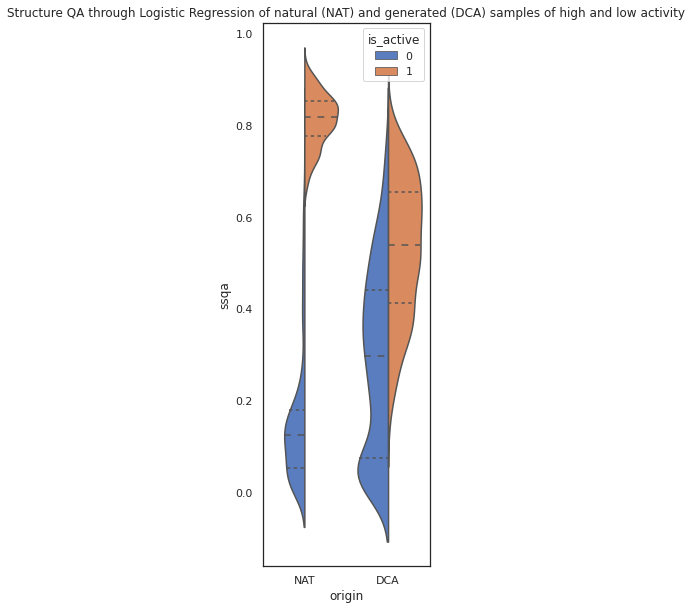

In [57]:
plt.figure(figsize=(10,10))
sns.swarmplot(x = "T", 
               y = "ssqa", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               palette = "muted",
               split = True,)
plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
#plt.ylim(-0.01, 1)
plt.show()

plt.figure(figsize=(3,10))
sns.violinplot(x = "origin", 
               y = "ssqa", 
               hue = "is_active", 
               data = df[df.edca_below_50 == 1], 
               inner = "quartile", 
               palette = "muted",
               split = True,)

plt.title("Structure QA through Logistic Regression of natural (NAT) and generated (DCA) samples of high and low activity")
#plt.ylim(-0.2, 1)
plt.show()

## Single Mutations

In [15]:
eccm = df.aligned_seq[0]
names = ["WT"]
aligned_seqs = [eccm]
for i, x in enumerate(eccm):
    for aa in AA+"-":
        names.append(f"{x}{i}{aa}")
        aligned_seqs.append(eccm[:i]+aa+eccm[i+1:])
unaligned_seqs = ["".join([x for x in v if x!="-"]) for v in aligned_seqs]
lengths = [len(v) for v in unaligned_seqs]

mut_df = pd.DataFrame(columns=["aligned_seq","seq","length"], index = names)
mut_df["aligned_seq"] = aligned_seqs
mut_df["seq"] = unaligned_seqs
mut_df["length"] = lengths
mut_df.to_csv(f"{DATA}/{MUT_DATASET}/sequences.csv")

In [16]:
dataset = SSQAData_QA(f"{DATA}/{MUT_DATASET}/data.pt")
dataset_rbm = SSQAData_RBM(f"{DATA}/{MUT_DATASET}/data.pt")

Available :  seq L cluster_index weights subset seq_hmm pattern ss_hmm
Available :  seq L cluster_index weights subset seq_hmm pattern ss_hmm


In [17]:
data_rbm = torch.cat([data[None] for data,_ in dataset_rbm],0)
mut_df["edca"] = model1.integrate_likelihood({"sequence":data_rbm}, "hidden").detach()/data_rbm.size(-1) - model1.Z

In [18]:
X = torch.cat([data[None] for data in dataset],0)

In [29]:
dp, pm = ssqa.featuring(X, None)
dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(dp, pm)

mut_df["pred_dot"] = dpsup
mut_df["pred_matching"] = pmsup
mut_df["pred_dot_unsupervised"] = dpunsup
mut_df["pred_matching_unsupervised"] = pmunsup

mut_df["ssqa_unsup"] = pmunsup
mut_df["ssqa_sup"] = (pmsup + dpsup)/2

In [30]:
heatmap_edca = torch.tensor(mut_df.edca.values[1:]).view(-1, 21)
heatmap_ssqa = torch.tensor(mut_df.ssqa_sup.values[1:]).view(-1, 21)
heatmap_both = 1.3 * heatmap_edca + heatmap_ssqa

In [31]:
ref_edca = mut_df.edca.values[0]
ref_ssqa = mut_df.ssqa_sup.values[0]
ref_both = 1.3 * mut_df.edca.values[0] + mut_df.ssqa_sup.values[0]

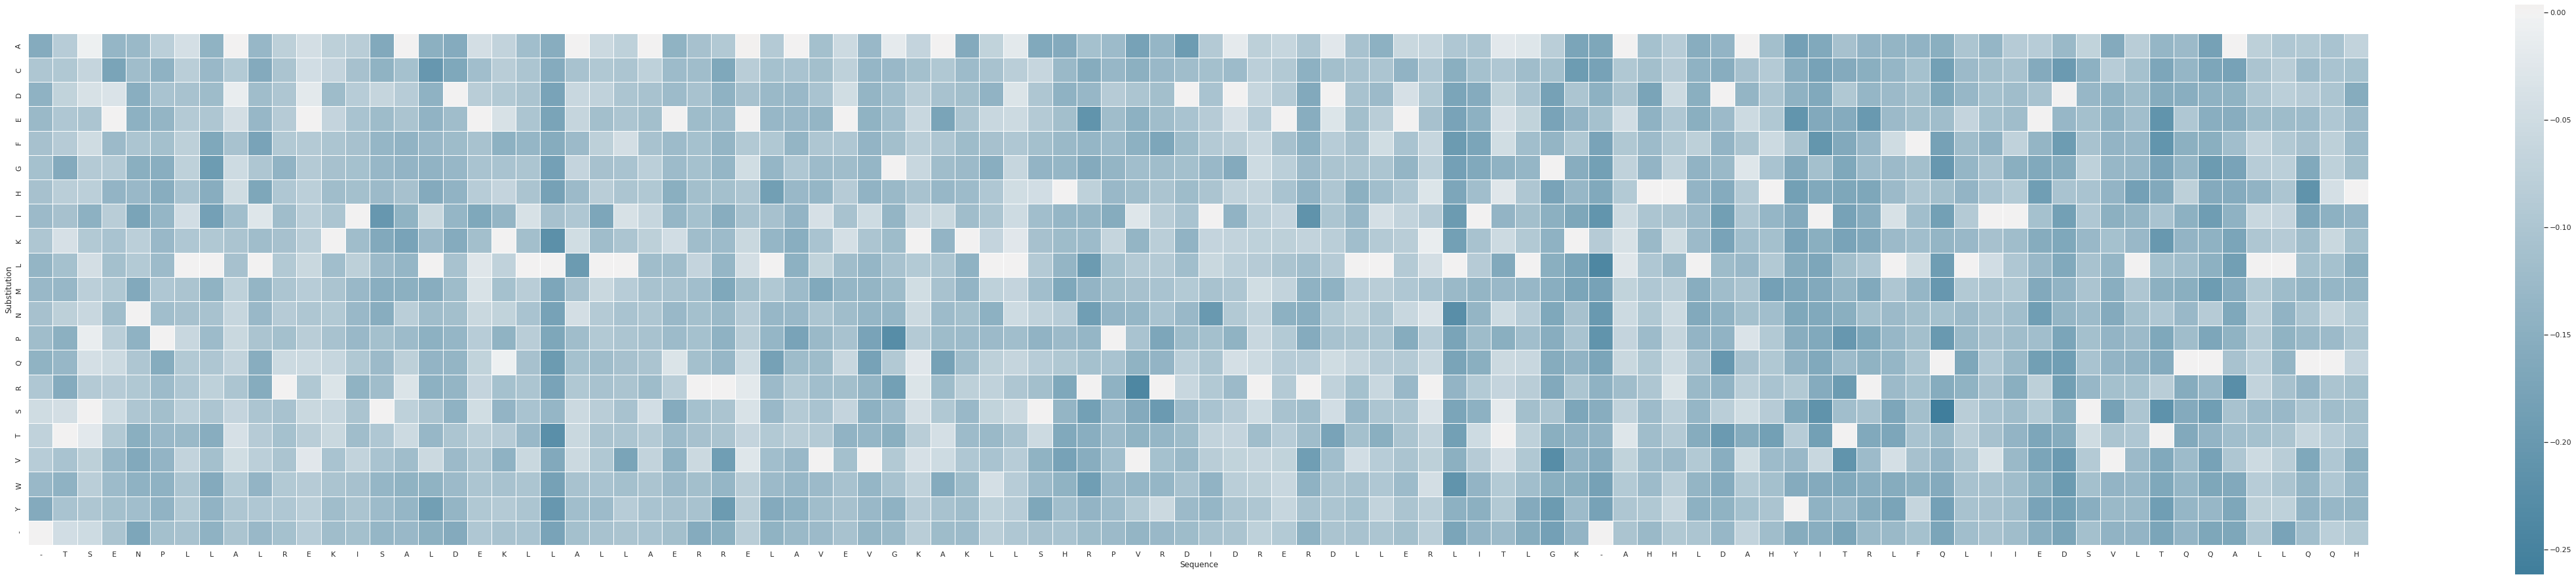

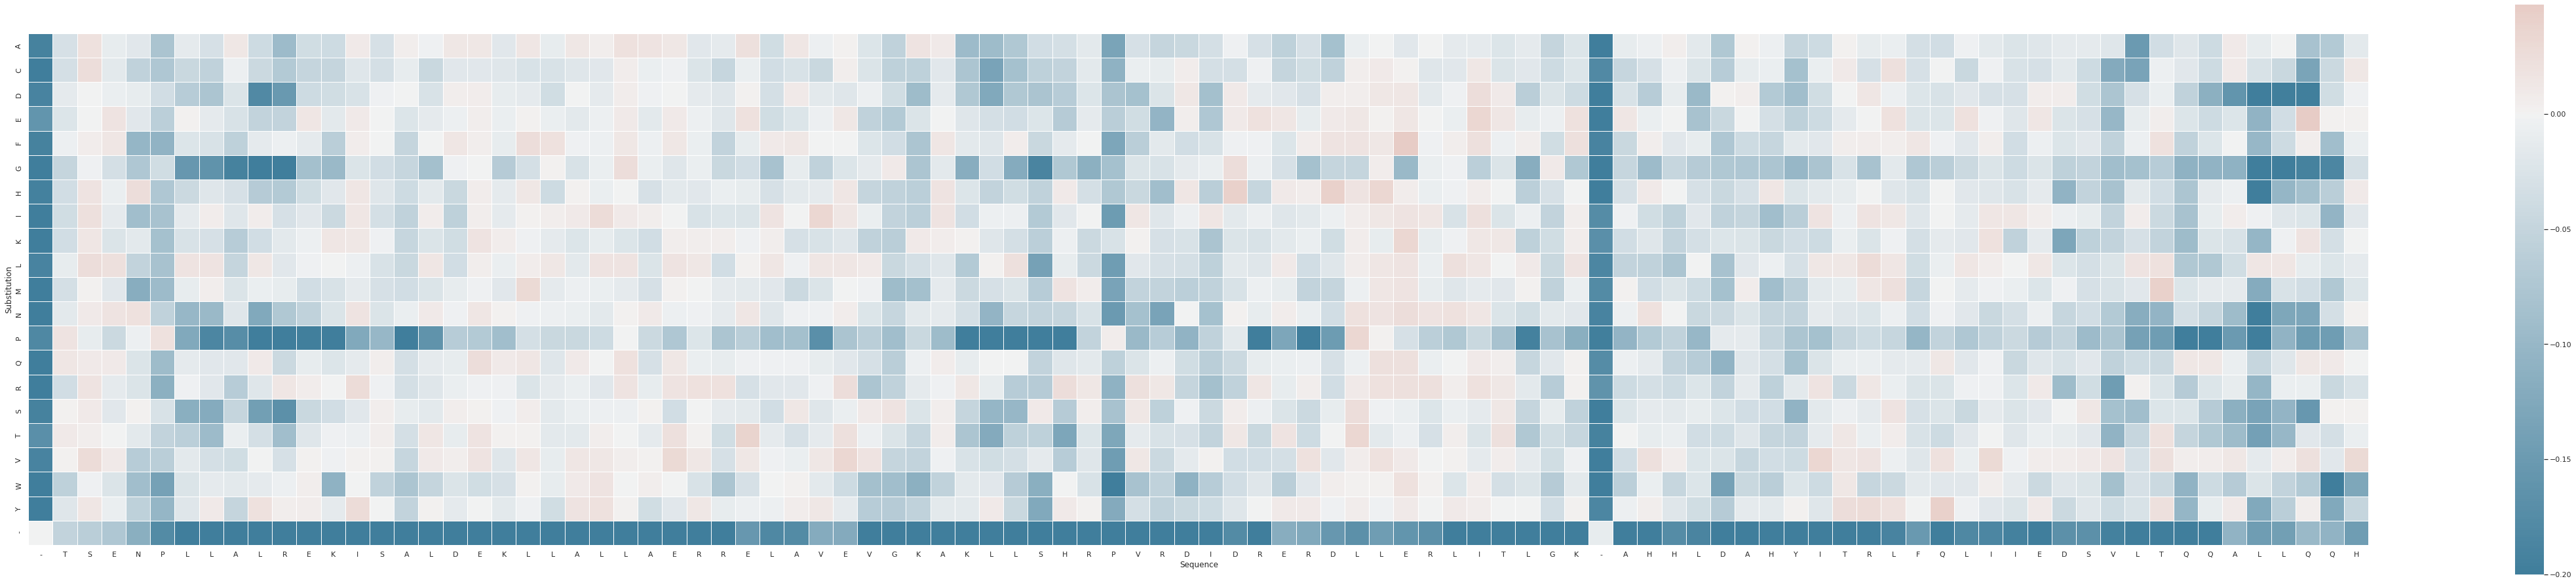

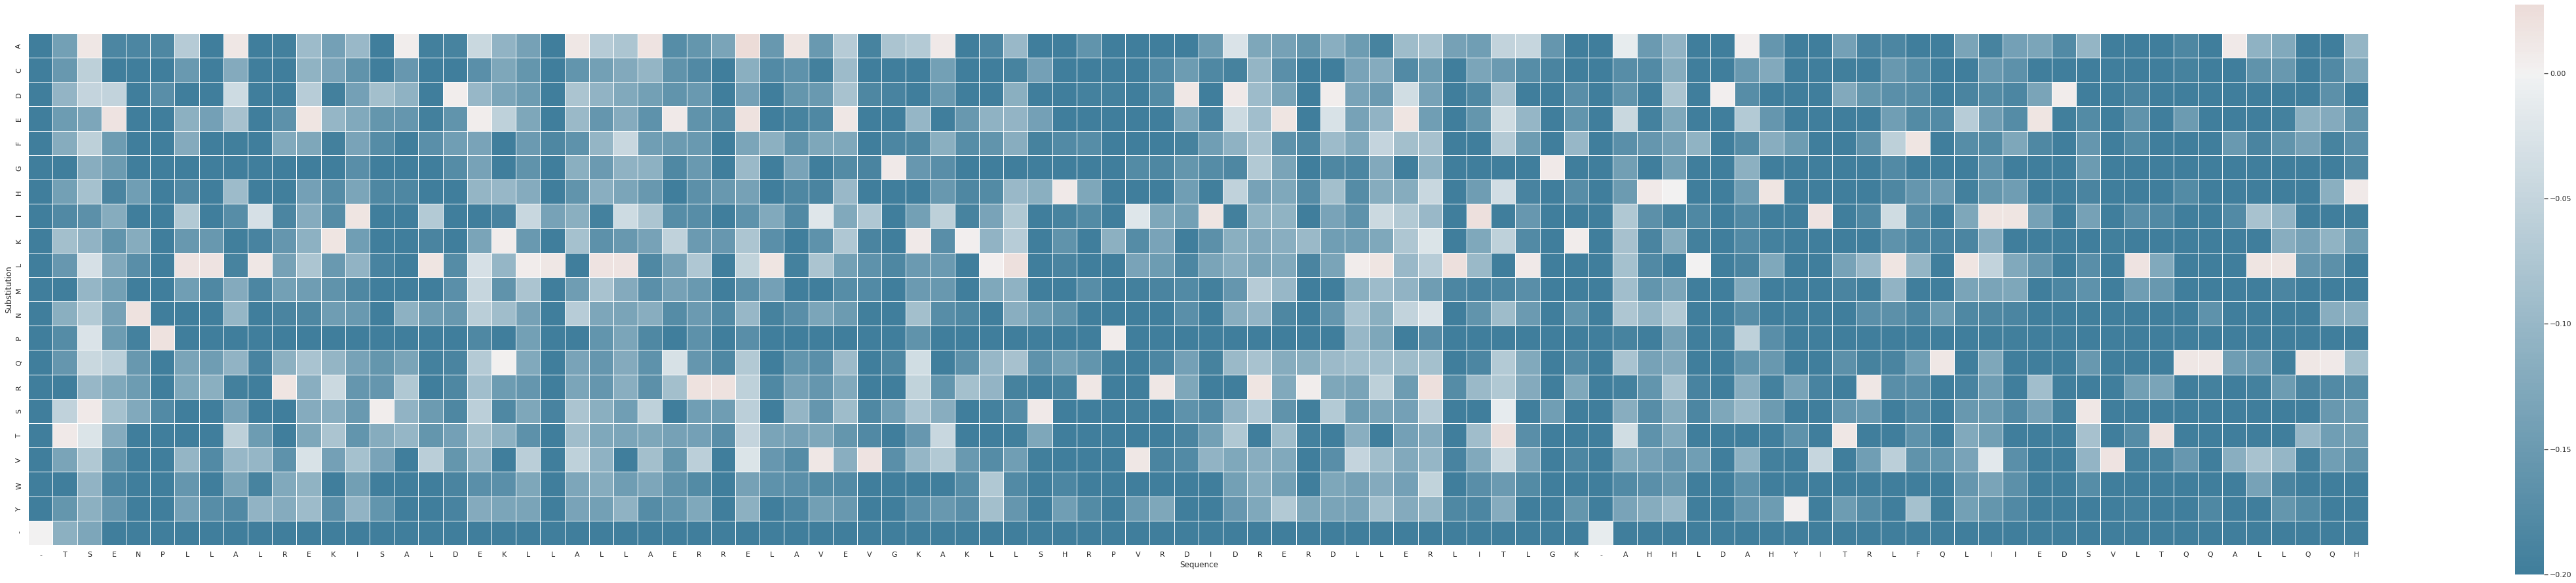

In [39]:
sns.set_theme(style="white")
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.set()
plt.figure(figsize = (80, 16))
sns.heatmap((heatmap_edca.T-ref_edca).numpy(), cmap = cmap, center = 0, xticklabels = eccm, yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

plt.figure(figsize = (80, 16))
sns.heatmap((heatmap_ssqa.T-ref_ssqa).clamp(-0.2).numpy(), cmap = cmap, center = 0, xticklabels = eccm, yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

plt.figure(figsize = (80, 16))
sns.heatmap((heatmap_both.T-ref_both).clamp(-0.2).numpy(), cmap = cmap, center = 0, xticklabels = eccm, yticklabels = AA+"-",
           square=True, linewidths=.1)
plt.xlabel("Sequence")
plt.ylabel("Substitution")
plt.show()

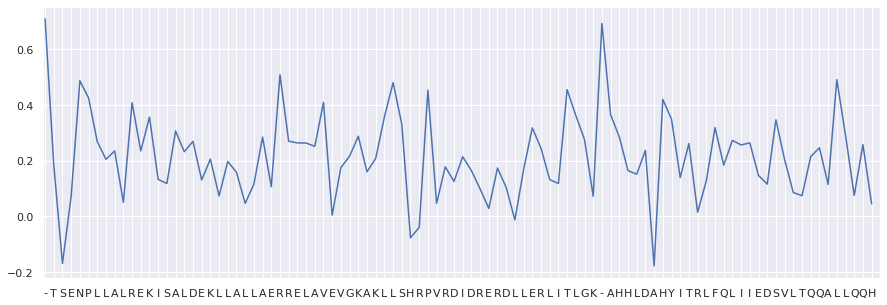

In [64]:
from scipy.stats import spearmanr,pearsonr

rho = []
for e,s in zip(heatmap_edca,heatmap_ssqa):
    rho.append(pearsonr(e,s)[0])

plt.figure(figsize=(15,5))
plt.plot(rho)
plt.xticks(range(len(rho)), eccm)
plt.xlim(-0.2,96)
plt.show()

## RBM with rejection

In [29]:
import os
all_files = [f[:-3] for f in os.listdir(f"{DATA}/{DATASET}/gen_data") if f[-3:] == ".pt"]
all_files.sort()

all_files = [f[:-3] for f in os.listdir(f"{DATA}/{DATASET}/gen_data") if f[-3:] == ".pt"]

all_files = ['rbm_local_rejection_sampling_T_0.5',
             'rbm_local_rejection_sampling_T_0.6',
             'rbm_local_rejection_sampling_T_0.65',
            'rbm_local_rejection_sampling_T_0.7',]

In [12]:
SSQA

ssqa.ssqa.SSQA

In [30]:
ssqa = SSQA(model_ss)
ssqa.model_ss = model_ss
ssqa.load(f"{DATA}/{DATASET}/ssqa.pt")

In [32]:
all_ssqa_sup, all_ssqa_unsup, all_edca, all_both = [],[],[],[]
for filename in all_files:
    ssqa_sup, ssqa_unsup, edca_, both = [],[],[],[]
    x = torch.load(f"{DATA}/{DATASET}/gen_data/{filename}.pt")
    
    for i in tqdm(range(len(x)//batch_size + 1)):
        x_ = x[i*batch_size:(i+1)*batch_size]
        e = model1.integrate_likelihood({"sequence":x_}, "hidden").detach()/data_rbm.size(-1) - model1.Z
        edca_.append(e)
        dp, pm = ssqa.featuring(x_[:,1:], None)
        dpunsup, pmunsup, dpsup, pmsup = ssqa.predict(dp, pm)
        ssqa_unsup.append(torch.tensor(pmunsup.detach()))
        ssqa_sup.append(torch.tensor((2/3 * dpsup + 1/3 * pmsup)))
        both.append(torch.tensor((2/5 * e.numpy()+ 2/5 * dpsup + 1/5 *pmsup)))
    all_ssqa_sup.append(torch.cat(ssqa_sup,0))
    all_ssqa_unsup.append(torch.cat(ssqa_unsup,0))
    all_edca.append(torch.cat(edca_,0))
    all_both.append(torch.cat(both,0))
all_ssqa_sup = torch.cat([t.view(1, *t.size()) for t in all_ssqa_sup],0)
all_ssqa_unsup = torch.cat([t.view(1, *t.size()) for t in all_ssqa_unsup],0)
all_edca = torch.cat([t.view(1, *t.size()) for t in all_edca],0)
all_both = torch.cat([t.view(1, *t.size()) for t in all_both],0)

100%|██████████| 1/1 [00:31<00:00, 31.84s/it]


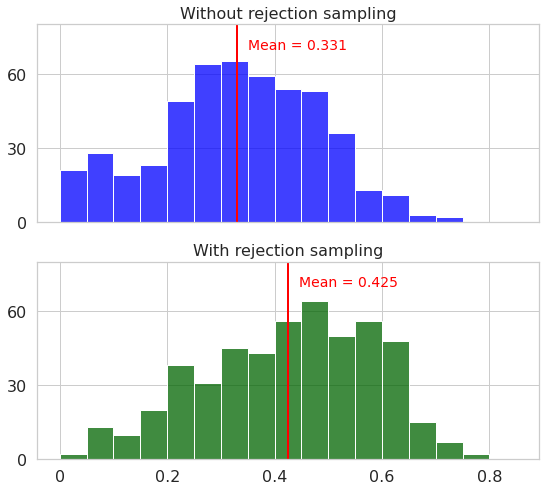

In [116]:
plt.figure(figsize=(9, 8))
plt.subplot(211)
sns.histplot(all_ssqa_sup[0], color = "blue",  bins = np.linspace(0, 0.85, 18))
plt.plot([m[0], m[0]], [0,90], color = "red", linewidth=2)
plt.yticks([0,30,60,90], [0,30,60,90], fontsize = 16)
plt.xticks([0,0.2,0.4,0.6,0.8], [], fontsize = 16)
plt.ylim(0,80)
plt.annotate(f"Mean = {m[0]:.3f}", (m[0]+0.02, 70), color = "red", fontsize = 14)
plt.title("Without rejection sampling", fontsize = 16)
plt.ylabel("", fontsize = 16)

#plt.ylabel("Number of sequences", fontsize = 16)


plt.subplot(212)
sns.histplot(all_ssqa_sup[2], color = "darkgreen", bins = np.linspace(0, 0.85, 18))
plt.yticks([0,30,60,90], [0,30,60,90], fontsize = 16)
plt.xticks([0,0.2,0.4,0.6,0.8], [0,0.2,0.4,0.6,0.8], fontsize = 16)
plt.ylim(0,80)
plt.plot([m[2], m[2]], [0,90], color = "red", linewidth=2)
plt.annotate(f"Mean = {m[2]:.3f}", (m[2]+0.02, 70), color = "red", fontsize = 14)

plt.title("With rejection sampling", fontsize = 16)
plt.ylabel("", fontsize = 16)


plt.show()